In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/research/prompt_engineering/RL
!pip install tiktoken
!pip install --upgrade "httpx<0.28"
import json
import rl
import utils
from openai import OpenAI
with open("config.json") as config_file:
    config = json.load(config_file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/research/prompt_engineering/RL


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
import pickle
from collections import deque
import torch
import random

# Replay Buffer with Save/Load
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action_loc, action_word, reward):
        """Add a transition to the replay buffer."""
        self.buffer.append((state, action_loc, action_word, reward))

    def sample(self, batch_size):
        """Sample a batch of transitions."""
        batch = random.sample(self.buffer, batch_size)
        states, actions_loc, actions_word, rewards = zip(*batch)
        return (
            torch.tensor(states),
            torch.tensor(actions_loc),
            torch.tensor(actions_word),
            torch.tensor(rewards)
        )

    def size(self):
        """Return the current size of the buffer."""
        return len(self.buffer)

    def save(self, file_path):
        """Save the replay buffer to a file."""
        with open(file_path, 'wb') as f:
            pickle.dump(self.buffer, f)

    def load(self, file_path):
        """Load the replay buffer from a file."""
        with open(file_path, 'rb') as f:
            self.buffer = pickle.load(f)

In [ ]:
replay_buffer = ReplayBuffer(capacity=1000)
replay_buffer.add([0.1, 0.2], 1, 1.0, [0.3, 0.4], False)
replay_buffer.add([0.5, 0.6], 0, 0.5, [0.7, 0.8], True)

# Save buffer to a file
replay_buffer.save("replay_buffer.pkl")

The OpenAI API does not have a direct parameter to set a random seed for reproducibility in its responses. The behavior of the models is inherently non-deterministic due to randomness in the generation process.

Replay buffer loaded.
Using device: cpu
Vocabulary size: 2274
Initial prompt: ['find', 'materials', 'entities', ' ', ' ', ' ']
Predictions: [['Functional amyloid', ' CsgA', ' FapC', ' hydrogels', ' gastrointestinal colonization', ' regenerative tissue engineering', ' cell-specific drug release', ' water-purification filters', ' biosensors.'], ['biomaterial-based strategies', ' immune system', ' physicochemical properties', ' drugs', ' proteins', ' mesenchymal stromal cells', ' synthetic nanostructures', ' biological nanostructures', ' extracellular vesicles', ' immunomodulators', ' therapeutic nanocarriers', ' biophysical properties'], ['immunometabolic cues', ' biomaterial microenvironment', ' immune cells', ' neutrophils', ' monocytes', ' chemokine receptor 2 (CCR2)', ' C-X3-C motif chemokine receptor 1 (CX3CR1)', ' amorphous polylactide implants', ' glycolytic inhibition', ' pro-regenerative microenvironment', ' myeloid cells']]
Scores: [0.6, 0.5714285714285715, 0.7777777777777778]


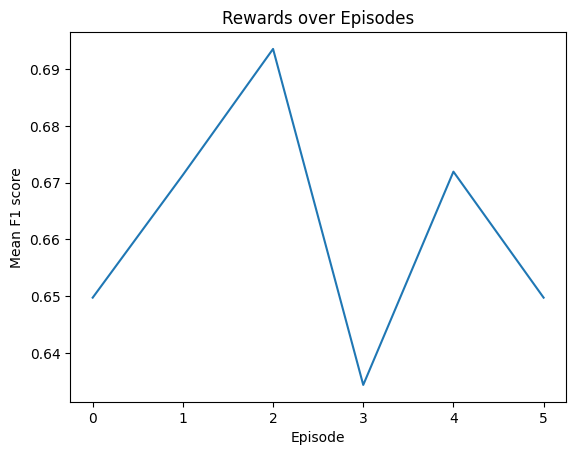

In [2]:
V_SIZE = 50000
WORD_LEN_MIN = 3
EPOCHS = 5
PROMPT_INIT = ["find", "materials", "entities", " ", " ", " "] # "Find entities for materials and devices"
FIXED_IDS = [0, 1, 2]
REPLAY = "replay_buffer_try"
LRs = [0.01, 1e-4]
HIDDENs = [64, 1024]
SEED = 1234
EXP_ID = 4
PRINT_INTERVAL = 1
SAVE = False
PLOT = True
DATASET = "biomaterials"

PROMPTS, PREDICTIONS, SCORES, REWARDS = rl.do_training(
    prompt_init=PROMPT_INIT, fixed_ids=FIXED_IDS, replay=REPLAY, epochs=EPOCHS, learning_rates=LRs,
    v_size=V_SIZE, word_len_min=WORD_LEN_MIN, hiddens=HIDDENs, seed=SEED,
    exp_id=EXP_ID, print_interval=PRINT_INTERVAL, save_results=SAVE, plot=PLOT,
    client=OpenAI(api_key=config["OPENAI_API_KEY"]), dataset=DATASET
    )

In [4]:
import pickle
with open("replay_buffer_try.pkl", 'rb') as f:
  test_transition = pickle.load(f)
len(test_transition)

10

In [ ]:
rl.do_test(prompt="find materials entities even lock way", save_results=False, client=OpenAI(api_key=config["OPENAI_API_KEY"]), dataset="biomaterials_eval")

Tested prompt: find materials entities even lock way
Predictions: [['Reactive oxygen species (ROS)', ' molecular oxygen', ' proteins', ' nucleic acids', ' lipids', ' inflammatory responses', ' inflammatory diseases.'], ['Chitosan', ' chitin', ' biopolymer', ' tissue regeneration', ' controlled drug delivery', ' nanoparticles', ' scaffolds', ' hydrogels', ' membranes'], ['pro-regenerative biomaterials', ' muscle injury treatment', ' BATF3-dependent dendritic cell population', ' cross-presentation', ' self-tolerance', ' E-cadherin', ' CD103', ' XCL-1', ' injured tissue', ' cell recruitment', ' trauma']]
Scores: [0.588235294117647, 0.6666666666666667, 0.4444444444444444]
Reward: 0.5664488017429193



In [ ]:
# results_metamaterials = utils.load_results("d_metamaterials_p_Find material entities._e_10_l_0.001_v_50000_len_7_h_64_s_1234_id_")
# results_piezoelectric = utils.load_results("d_piezoelectric_p_Find material entities._e_10_l_0.001_v_50000_len_7_h_64_s_1234_id_")
# results_biomaterials = utils.load_results("d_biomaterials_p_Find material entities._e_10_l_0.001_v_50000_len_7_h_64_s_1234_id_")
# utils.plot_results_multiple([results_metamaterials, results_piezoelectric, results_biomaterials],
#                             labels=["Metamaterials", "Piezoelectric materials", "Biomaterials"], fontsize=12, figsize=(8, 6))
# all_results = utils.load_results("d_metamaterials_p_Find material entities._e_10_l_0.001_v_100000_len_7_h_64_s_1234_id")
# utils.plot_results(all_results, fontsize=12, figsize=(8, 6))